In [1]:
pip install statsmodels

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

In [3]:
plik = pd.read_csv('single-cell-tracks_exp1-6_noErbB2.csv.gz')
metadata = pd.read_csv('01-readme-experiment-description_2022-04-05.csv')

In [4]:
print(plik.columns)
# /\ wypisuje nazwy wszystkich kolumn

print(metadata.columns)

Index(['Exp_ID', 'Image_Metadata_Site', 'track_id', 'Image_Metadata_T',
       'Nuclear_size', 'ERKKTR_ratio', 'FoxO3A_ratio',
       'objNuclei_Location_Center_X', 'objNuclei_Location_Center_Y'],
      dtype='object')
Index(['Site', 'Cell_Line', 'Mutation', 'Biosensors', 'Conditions',
       'Acquisition_frequency_min', 'Duration_h'],
      dtype='object')


In [5]:
#Tworzę słownik mutacji z pliku metadata
site_to_mutation = dict(zip(metadata['Site'], metadata['Mutation']))

# Mapuję słownik do danych z pliku tworząc nową kolumnę z typem mutacji
plik['Mutation'] = plik['Image_Metadata_Site'].map(site_to_mutation)


In [6]:
print(plik.columns)
# /\ wypisuje nazwy wszystkich kolumn

print(metadata.columns)

Index(['Exp_ID', 'Image_Metadata_Site', 'track_id', 'Image_Metadata_T',
       'Nuclear_size', 'ERKKTR_ratio', 'FoxO3A_ratio',
       'objNuclei_Location_Center_X', 'objNuclei_Location_Center_Y',
       'Mutation'],
      dtype='object')
Index(['Site', 'Cell_Line', 'Mutation', 'Biosensors', 'Conditions',
       'Acquisition_frequency_min', 'Duration_h'],
      dtype='object')


In [7]:
#grupujemy komórki po czasie i typie
grouped = plik.groupby(['Image_Metadata_T', 'Mutation']).agg({
    'ERKKTR_ratio': ['mean', 'std'],
    'FoxO3A_ratio': ['mean', 'std']
}).reset_index()

# Zmiana kolumn dla łatwiejszej analizy
grouped.columns = ['Time', 'Mutation', 'ERK_mean', 'ERK_std', 'AKT_mean', 'AKT_std']

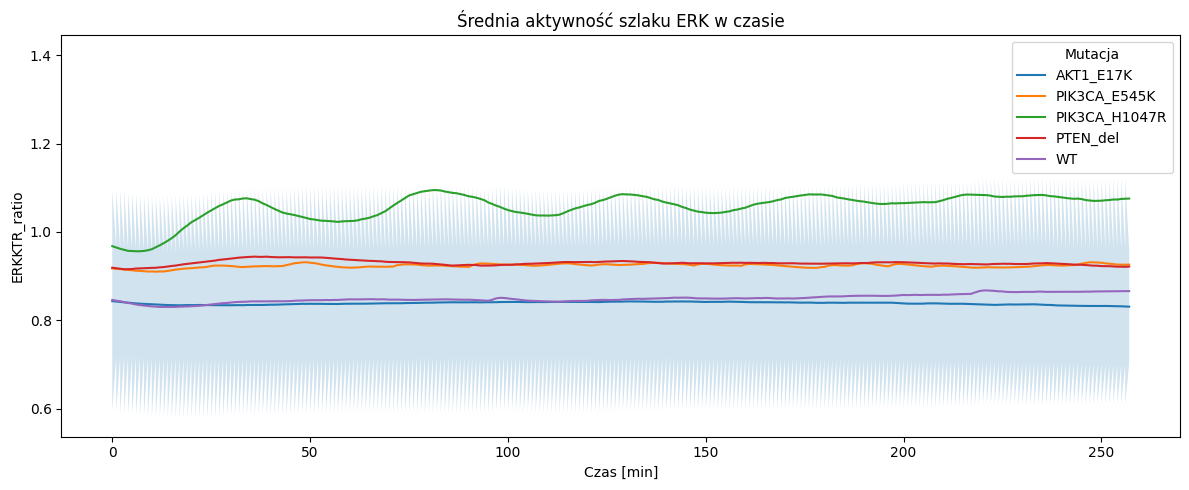

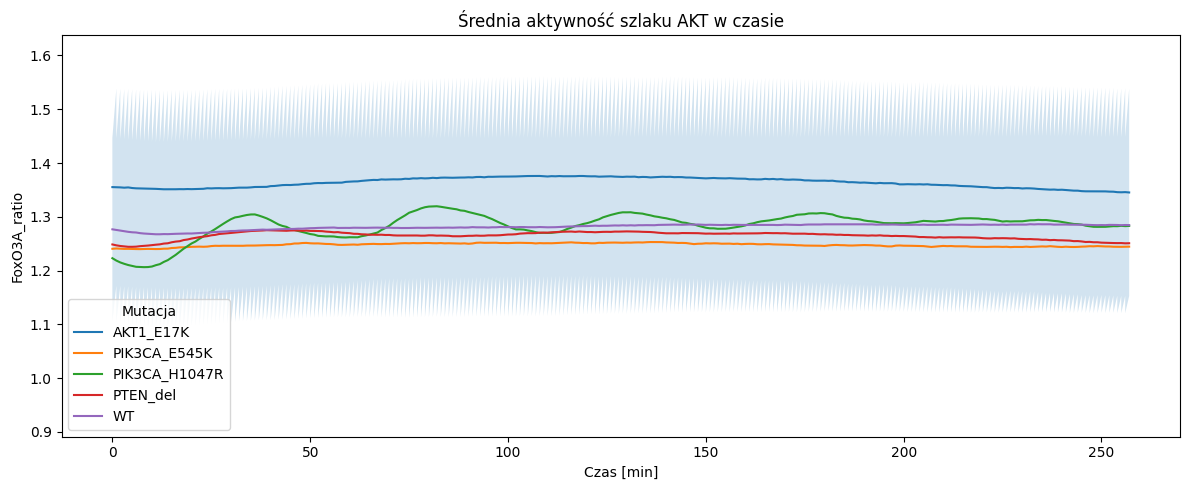

In [8]:
# Wykres aktywności dla ERK
plt.figure(figsize=(12, 5))
sns.lineplot(data=grouped, x='Time', y='ERK_mean', hue='Mutation')
plt.fill_between(grouped['Time'], grouped['ERK_mean'] - grouped['ERK_std'], 
                 grouped['ERK_mean'] + grouped['ERK_std'], alpha=0.2)
plt.title('Średnia aktywność szlaku ERK w czasie')
plt.xlabel('Czas [min]')
plt.ylabel('ERKKTR_ratio')
plt.legend(title='Mutacja')
plt.tight_layout()
plt.show()

# Wykres aktywności dla AKT
plt.figure(figsize=(12, 5))
sns.lineplot(data=grouped, x='Time', y='AKT_mean', hue='Mutation')
plt.fill_between(grouped['Time'], grouped['AKT_mean'] - grouped['AKT_std'], 
                 grouped['AKT_mean'] + grouped['AKT_std'], alpha=0.2)
plt.title('Średnia aktywność szlaku AKT w czasie')
plt.xlabel('Czas [min]')
plt.ylabel('FoxO3A_ratio')
plt.legend(title='Mutacja')
plt.tight_layout()
plt.show()


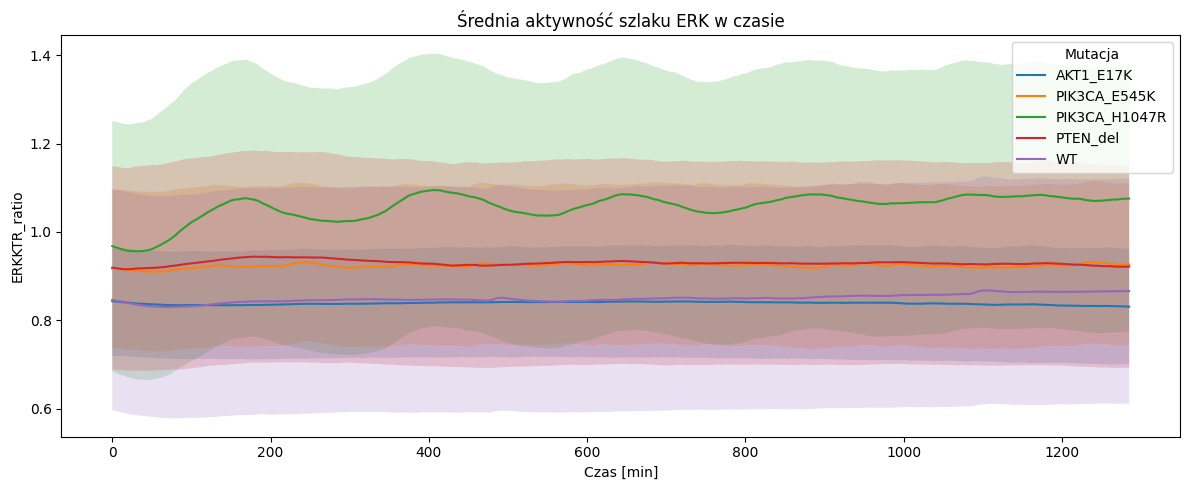

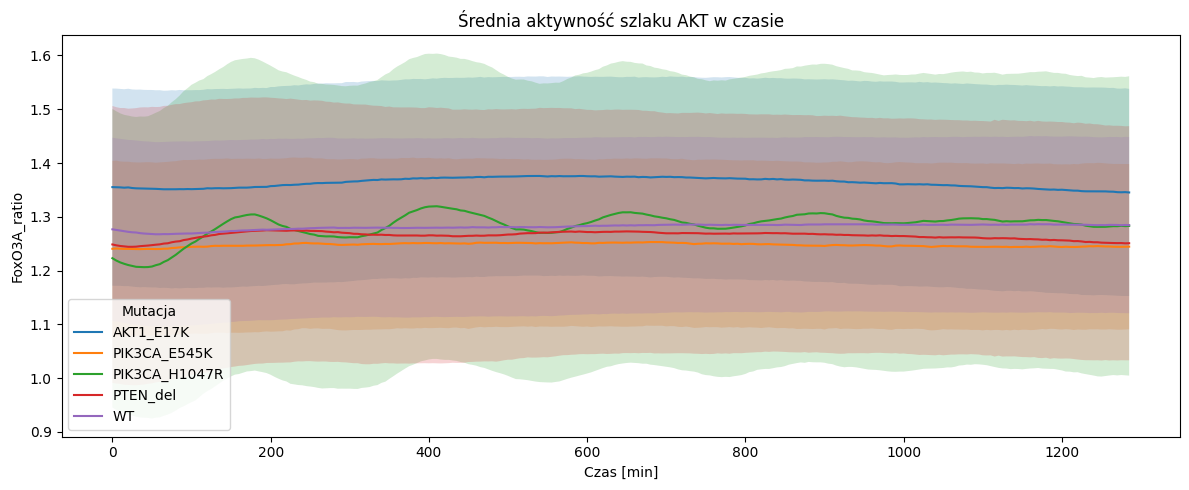

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Skala minutowa
grouped['Time_min'] = grouped['Time'] * 5

# Wykres ERK
plt.figure(figsize=(12, 5))
for mutation in grouped['Mutation'].unique():
    data = grouped[grouped['Mutation'] == mutation]
    plt.plot(data['Time_min'], data['ERK_mean'], label=mutation)
    plt.fill_between(data['Time_min'],
                     data['ERK_mean'] - data['ERK_std'],
                     data['ERK_mean'] + data['ERK_std'],
                     alpha=0.2)

plt.title('Średnia aktywność szlaku ERK w czasie')
plt.xlabel('Czas [min]')
plt.ylabel('ERKKTR_ratio')
plt.legend(title='Mutacja')
plt.tight_layout()
plt.show()

# Wykres AKT
plt.figure(figsize=(12, 5))
for mutation in grouped['Mutation'].unique():
    data = grouped[grouped['Mutation'] == mutation]
    plt.plot(data['Time_min'], data['AKT_mean'], label=mutation)
    plt.fill_between(data['Time_min'],
                     data['AKT_mean'] - data['AKT_std'],
                     data['AKT_mean'] + data['AKT_std'],
                     alpha=0.2)

plt.title('Średnia aktywność szlaku AKT w czasie')
plt.xlabel('Czas [min]')
plt.ylabel('FoxO3A_ratio')
plt.legend(title='Mutacja')
plt.tight_layout()
plt.show()


In [10]:
# Subset for selected time window
subset = plik[(plik['Image_Metadata_T'] >= 60) & (plik['Image_Metadata_T'] <= 180)]

# Average per cell over the window to avoid pseudoreplication
cell_means = subset.groupby(['track_id', 'Mutation'])[['ERKKTR_ratio', 'FoxO3A_ratio']].mean().reset_index()

# Compare each mutation to WT
mutations = cell_means['Mutation'].unique()
mutations = [m for m in mutations if m != 'WT']

results = []
for mut in mutations:
    for signal in ['ERKKTR_ratio', 'FoxO3A_ratio']:
        wt_vals = cell_means[cell_means['Mutation'] == 'WT'][signal]
        mut_vals = cell_means[cell_means['Mutation'] == mut][signal]
        stat, p = mannwhitneyu(wt_vals, mut_vals, alternative='two-sided')
        results.append((mut, signal, p))

# Multiple testing correction
df_p = pd.DataFrame(results, columns=['Mutation', 'Signal', 'p_value'])
df_p['p_adj'] = multipletests(df_p['p_value'], method='bonferroni')[1]

print(df_p)

        Mutation        Signal        p_value          p_adj
0      AKT1_E17K  ERKKTR_ratio   6.589212e-02   5.271370e-01
1      AKT1_E17K  FoxO3A_ratio  2.439027e-124  1.951222e-123
2   PIK3CA_E545K  ERKKTR_ratio  1.979419e-186  1.583535e-185
3   PIK3CA_E545K  FoxO3A_ratio  7.608408e-106  6.086727e-105
4  PIK3CA_H1047R  ERKKTR_ratio   0.000000e+00   0.000000e+00
5  PIK3CA_H1047R  FoxO3A_ratio   1.925506e-01   1.000000e+00
6       PTEN_del  ERKKTR_ratio  3.564764e-237  2.851811e-236
7       PTEN_del  FoxO3A_ratio   2.772225e-15   2.217780e-14


In [11]:
#####################################Zad2

In [12]:
import pandas as pd
pd.options.mode.string_storage = 'python'


In [13]:
import numpy as np

# Wybieramy ścieżkę sygnałową (np. ERK)
signal_col = 'ERKKTR_ratio'

# Obliczamy baseline dla każdej komórki
def define_baseline(group):
    baseline = group[signal_col].quantile(0.1)
    std = group[signal_col].std()
    group['is_active'] = group[signal_col] > (baseline + std)
    return group

pogrupowany_plik = plik.groupby('track_id').apply(define_baseline)
print('zrobione')

MemoryError: Unable to allocate 271. MiB for an array with shape (35541648,) and data type int64

In [ ]:
import dask.dataframe as dd
import numpy as np

plik_dd = dd.read_csv('plik.csv')  # jeśli masz CSV



In [ ]:
from scipy.spatial import KDTree

radius = 50  # np. 50 jednostek (μm) – trzeba dobrać do skali zdjęcia
neighbor_stats = []

# Iteracja po klatkach czasowych
for t in sorted(plik['Image_Metadata_T'].unique()):
    frame = plik[plik['Image_Metadata_T'] == t]
    active = frame[frame['is_active']]
    
    if len(active) == 0:
        continue

    coords = frame[['objNuclei_Location_Center_X', 'objNuclei_Location_Center_Y']].values
    kd = KDTree(coords)

    # Mapa track_id -> index w ramce
    id_to_idx = dict(zip(frame['track_id'], range(len(frame))))
    
    # Aktywne komórki i ich indeksy
    active_idxs = frame[frame['is_active']].index

    # Dla każdej aktywnej komórki policz aktywnych sąsiadów
    for idx in active_idxs:
        row = frame.loc[idx]
        pt = [row['objNuclei_Location_Center_X'], row['objNuclei_Location_Center_Y']]
        neighbors_idx = kd.query_ball_point(pt, r=radius)

        # Ilu sąsiadów w promieniu też jest aktywnych?
        active_neighbor_count = frame.iloc[neighbors_idx]['is_active'].sum() - 1  # -1 bo liczy też siebie
        neighbor_stats.append({
            'Time': t * 5,
            'track_id': row['track_id'],
            'Mutation': row['Mutation'],
            'Active_neighbors': active_neighbor_count
        })

neighbor_df = pd.DataFrame(neighbor_stats)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

summary = neighbor_df.groupby(['Time', 'Mutation'])['Active_neighbors'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=summary, x='Time', y='Active_neighbors', hue='Mutation')
plt.title('Średnia liczba aktywnych sąsiadów w czasie')
plt.xlabel('Czas [min]')
plt.ylabel('Średnia liczba aktywnych sąsiadów')
plt.legend(title='Mutacja')
plt.tight_layout()
plt.show()


In [ ]:
#########################Zad3

In [22]:
# Filtr danych: 200–1000 minut po rozpoczęciu eksperymentu
# Używamy go, żeby zniwelować efekty wahań na początku i na końcu obserwacji (widoczne na wykresach z zad 1)
df_filtered = plik[(plik['Image_Metadata_T'] >= 200) & (plik['Image_Metadata_T'] <= 1000)]


In [23]:
# Agregacja: średnie z obserwacji dla każdej komórki
cell_summary = df_filtered.groupby('track_id').agg({
    'Nuclear_size': 'mean',
    'ERKKTR_ratio': 'mean',
    'FoxO3A_ratio': 'mean'
}).reset_index()


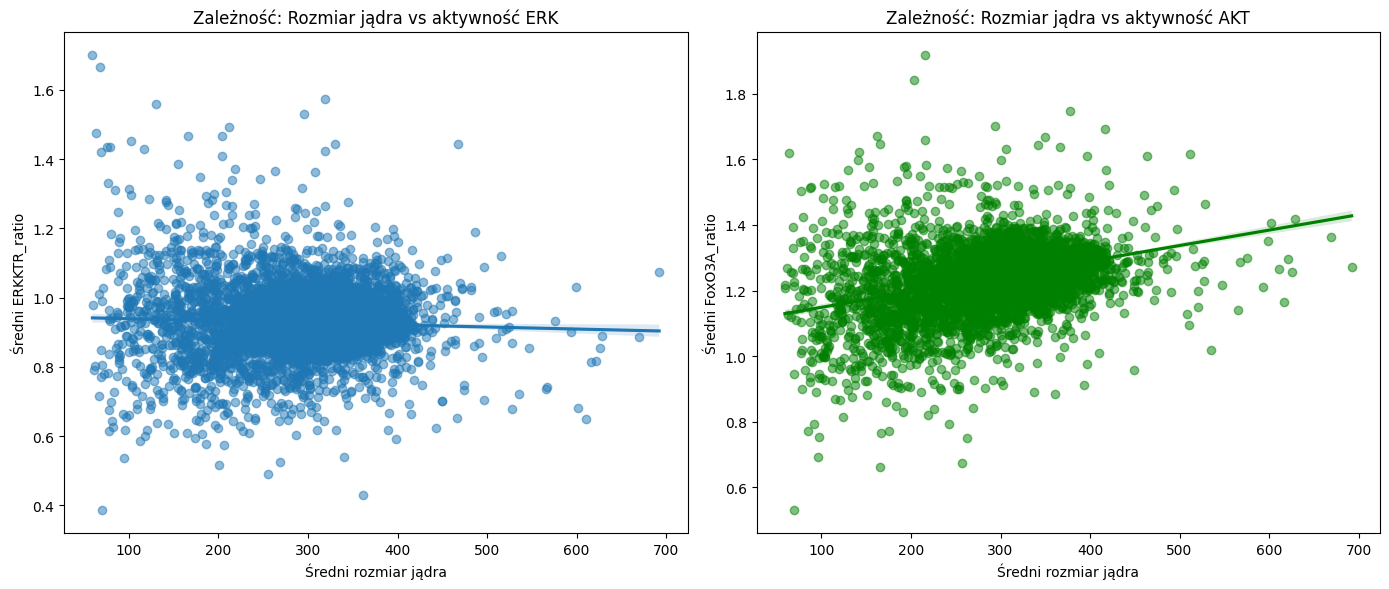

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# ERK vs Nuclear size
plt.subplot(1, 2, 1)
sns.regplot(data=cell_summary, x='Nuclear_size', y='ERKKTR_ratio', scatter_kws={'alpha':0.5})
plt.title('Zależność: Rozmiar jądra vs aktywność ERK')
plt.xlabel('Średni rozmiar jądra')
plt.ylabel('Średni ERKKTR_ratio')

# AKT vs Nuclear size
plt.subplot(1, 2, 2)
sns.regplot(data=cell_summary, x='Nuclear_size', y='FoxO3A_ratio', scatter_kws={'alpha':0.5}, color='green')
plt.title('Zależność: Rozmiar jądra vs aktywność AKT')
plt.xlabel('Średni rozmiar jądra')
plt.ylabel('Średni FoxO3A_ratio')

plt.tight_layout()
plt.show()


In [25]:
from scipy.stats import pearsonr, spearmanr

# Korelacja dla ERK
pearson_erk = pearsonr(cell_summary['Nuclear_size'], cell_summary['ERKKTR_ratio'])
spearman_erk = spearmanr(cell_summary['Nuclear_size'], cell_summary['ERKKTR_ratio'])

# Korelacja dla AKT
pearson_akt = pearsonr(cell_summary['Nuclear_size'], cell_summary['FoxO3A_ratio'])
spearman_akt = spearmanr(cell_summary['Nuclear_size'], cell_summary['FoxO3A_ratio'])

print("Korelacja ERK (Pearson):", round(pearson_erk[0], 3), "p =", round(pearson_erk[1], 4))
print("Korelacja ERK (Spearman):", round(spearman_erk[0], 3), "p =", round(spearman_erk[1], 4))

print("Korelacja AKT (Pearson):", round(pearson_akt[0], 3), "p =", round(pearson_akt[1], 4))
print("Korelacja AKT (Spearman):", round(spearman_akt[0], 3), "p =", round(spearman_akt[1], 4))


Korelacja ERK (Pearson): -0.047 p = 0.0006
Korelacja ERK (Spearman): -0.008 p = 0.5626
Korelacja AKT (Pearson): 0.366 p = 0.0
Korelacja AKT (Spearman): 0.386 p = 0.0
